<a href="https://colab.research.google.com/github/onishchenkoar/dungeons-and-dragons-and-probability/blob/main/fenthras_vs_lss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Is Fenthras better than Longbow of Sky Sentinel?
TL;DR YES.

## Introduction
On episode 63 of Critical Role (first campaign), Vex'ahlia acquired a legendary bow: Fenthras. I did not think of it much at the time, but I have stumbled upon a [thread on Reddit](https://www.reddit.com/r/criticalrole/comments/59fans/spoilers_e72_what_is_the_difference_in_damage/) with a discussion of the utility of Fenthras. Her previous bow &mdash; Longbow of Sky Sentinel &mdash; has a special attack that allows to shoot three arrows at a time, can Fenthras compare? People's math on the thread is loosey-goosey, but there is a rigorous way to calculate expected  damage using probability theory and some Python code.

## Preparation
### Bows' stats

#### Fenthras
According to *Tal'Dorei Campaign Setting*, p.113, Fenthras has three states: Dormant, Awakened, Exalted. On an episode of Talks Machina, the Dungeon Master [says](https://youtu.be/dQBPIyQe60s?t=5032) that Fenthras is Exalted. It means that the bow gives +3 to attack bonus and damage, each attack has 1d6 extra lightning damage. Additionally, there is a special attack called Bramble Shot: 3d8 additional damage and the target has to make a strength saving throw against DC 17, getting Restrained on failure.

So, for Vex, at level 15 (the level when she got Fenthras): 
* total attack bonus is: 5 proficiency + 5 DEX + 2 from Archery Fighting Style + 3 from Fenthras = 15;
* the damage is: 1d8 from being a longbow + 1d6 lightning + 5 DEX + 3 from Fenthras.

In [ ]:
from dndrv import * # get D6, D8

# Fenthras stats:
FEN_ATK_BONUS = 15
FEN_VANILLA_DICE_DMG = D8 + D6 + D6 # piercing + lightning + Hunter's Mark
FEN_DMG_MOD = 8
FEN_BRAMBLE_SHOT_DICE_DMG = sum(3 * [D8]) # piercing
FEN_BRAMBLE_SHOT_DC = 17

#### Longbow of Sky Sentinel
According to Mercer's [message on Twitter](https://twitter.com/matthewmercer/status/766800029885591552?lang=en), Longbow of Sky Sentinel has a longbow damage (1d8), +2 bonus to attack and damage. There is a special attack called Storm Arrow: the bow shoots three arrows, each of which deals additional 1d6 lightning damage on a successful hit.

For Vex, at level 15:
* total attack bonus is: 5 proficiency + 5 DEX + 2 from Archery Fighting Style + 2 from Longbow of Sky Sentinel = 14;
* the damage is: 1d8 from being a longbow + 5 DEX + 2 from Longbow of Sky Sentinel.

In [ ]:
# Longbow of Sky Sentinel stats:
LSS_ATK_BONUS = 14
LSS_VANILLA_DICE_DMG = D8 + D6 # piercing + Hunter's Mark
LSS_STORM_ARROW_DICE_DMG = D6 # lighting 
LSS_DMG_MOD = 7

### Let's define the setting
#### Varying parameters
I want to calculate damages for both bows varying several parameters:
1. Target's armor class &mdash; determines the likelyhood with which a shot hits.
2. Target's strength saving throw &mdash; determines the likelyhood with which the target gets Restrained after being hit with Bramble Shot.
3. Number of combat rounds.

I found [a spreadsheet](https://docs.google.com/spreadsheets/d/10anA394CmxeLYTxuMYVnmmjiYLLedXfv6MBbpxEy2Kw/edit#gid=0) with monster stats. According to it:
* lowest AC for a monster: 5;
* highest AC for a monster: 25;
* lowest STR save for a monster: -5;
* highest STR save for a monster: 17.

#### Assumptions for the combat
1. All attacks go to a single target.
1. Vex uses Hunter's Mark at the very beginning, which gives 1d6 additional damage on each successful hit afterwards.
1. When using Fenthras, Bramble Shot goes as the first hit (the most beneficial option).
1. Despite Exalted Fenthras being able to fire Bramble shot twice a day, it is used once per combat. This is how it happens in the game. I don't know why.
1. The target does not have resistances or immunities to piercing or lightning damage.
1. Vex gets neither advantage nor disadvantage on attacks, except for the advantage from the target being Restrained after the Bramble Shot.
1. The target has neither advantage nor disadvantage on its saving throws.
1. The combat lasts for 8 rounds most (just 'cause).
1. Damage done by allies is irrelevant to the question.
1. The bow that has higher expected value of damage is better.

In [ ]:
# Combat and target parameters:
MAX_ROUNDS = 8
TARGET_AC_MIN = 5
TARGET_AC_MAX = 25
TARGET_STR_SAVE_MIN = -5
TARGET_STR_SAVE_MAX = 17


## Some math
Formula for a probability distribution of damage dealt with a weapon attack:
$$\text{DMG} = R_{atk}^{\{0, 1\}} \cdot (\text{dmg_dice} + \text{dmg_mod} + R_{crit}^{\{1, 2\}})$$
where
* $R_{atk}^{\{0, 1\}}$ &mdash; a binary random variable that can be either 0 or 1; determines the likelyhood of hitting a target;
* $R_{crit}^{\{1, 2\}}$ &mdash; a binary random variable that can be either 1 or 2; determines the likelyhood of a critical damage;
* $\text{dmg_dice}$ &mdash; a random variable that determines a probability distribution of the sum of all dice rolled for damage; will change depending on which attack is being used;
* $\text{dmg_mod}$ &mdash; a constant component of damage: 8 for Fenthras, 7 for Longbow of Sky Sentinel.

## Some code
I wrote a class `My_rv` that allows me to add, subtract, and multiply random variables (based on SciPy's `rv_discrete` class). For example, this is a probability distribution of 4d6 (sum of points in 4 rolls of a 6-sided die):
![4d6 roll](./pics/4d6.png)

Another thing I need is to predetermine a binary (success/failure) random variable for d20 rolls. `d20_outcome` function does that.

Also, note that Vex can have advantage after Bramble shot (because of Restrained). This having advantage depends on the target's saving throw. This means that having advantage is _probabilistic_. With each new round, the probability of target being restrained gets lower and lower. I handle that in `fen_consecutive_hit`. 

The code below uses NumPy and Scikit-learn. `dndrv`  is my on module which contains `My_rv`, `d20_outcome`, and random variables for simple dice rolls, e.g. `D6` is a random variable for 1d6.







In [ ]:
import numpy as np
from sklearn import tree

from dndrv import *


def fen_consecutive_hit(p_save_fail, target_ac):
  """
  Returns a random variable of damage dealt with a plain shot with Fenthras.

  p_save_fail -- probability of failing a strength saving throw against Bramble Shot.

  target_ac -- Armor Class of the target.
  """

  pk = D20_ADV.pk * p_save_fail + D20.pk * (1 - p_save_fail)
  fen_d20_distr = My_rv(values=(D20.xk, pk))
  fen_roll_to_hit_rv = d20_outcome(fen_d20_distr, target_ac, modifier=FEN_ATK_BONUS,
                                   crit_fail_values=[1], crit_success_values=[20])
  fen_crit_rv = d20_outcome(fen_d20_distr, float('inf'), crit_success_values=[20]) + 1
  return fen_roll_to_hit_rv * (FEN_DMG_MOD + fen_crit_rv*FEN_VANILLA_DICE_DMG)


x = np.zeros((1, 3))
y = np.array([0])
s = 'Rounds, Target AC, STR save, Winner \n'
for target_ac in range(TARGET_AC_MIN, TARGET_AC_MAX + 1):
  for str_save in range(TARGET_STR_SAVE_MIN, TARGET_STR_SAVE_MAX + 1):
    # Probability of failing a STR saving throw against being restrained.
    str_save_rv = d20_outcome(D20, FEN_BRAMBLE_SHOT_DC, modifier=str_save,
                              crit_fail_values=[1],
                              crit_success_values=[20])
    p_single_save_fail = str_save_rv.pk[0]
    fen_first_hit_rv = d20_outcome(D20, target_ac, modifier=FEN_ATK_BONUS,
                                   crit_fail_values=[1],
                                   crit_success_values=[20])
    fen_first_hit_crit_rv = My_rv(values=([1, 2], [0.95, 0.05]))
    fen_dice_dmg = FEN_VANILLA_DICE_DMG + FEN_BRAMBLE_SHOT_DICE_DMG
    fen_first_hit_dmg = fen_first_hit_rv\
                         * (FEN_DMG_MOD + fen_first_hit_crit_rv*fen_dice_dmg)
    p_save_fail = p_single_save_fail
    fen_first_round_dmg = fen_first_hit_dmg\
                          + fen_consecutive_hit(p_save_fail, target_ac)

    # Easier for LSS, because there is no restraining.
    lss_roll_to_hit_rv = d20_outcome(D20, target_ac, modifier=LSS_ATK_BONUS,
                                     crit_fail_values=[1], crit_success_values=[20])
    lss_crit_rv = My_rv(values=([1, 2], [0.95, 0.05]))
    lss_dice_dmg = LSS_VANILLA_DICE_DMG + LSS_STORM_ARROW_DICE_DMG
    lss_storm_arrow = lss_roll_to_hit_rv * (LSS_DMG_MOD + lss_crit_rv*lss_dice_dmg)
    lss_one_shot = lss_roll_to_hit_rv * (LSS_DMG_MOD + lss_crit_rv*LSS_VANILLA_DICE_DMG)
    lss_first_round_dmg = sum(3 * [lss_storm_arrow]) + lss_one_shot

    fen_total_dmg = fen_first_round_dmg
    lss_total_dmg = lss_first_round_dmg

    winner = 'Fenthras' if fen_total_dmg.mean() > lss_total_dmg.mean() else 'Sky Sentinel'
    s += f'1, {target_ac}, {str_save}, {winner}\n'
    x = np.append(x, [[1, target_ac, str_save]], 0)
    y = np.append(y, winner)

    for i_round in range(2, MAX_ROUNDS + 1):
      p_save_fail *= p_single_save_fail      
      fen_total_dmg += sum(2 * [fen_consecutive_hit(p_save_fail, target_ac)])
      lss_total_dmg += sum(2 * [lss_one_shot])
      winner = 'Fenthras' if fen_total_dmg.mean() > lss_total_dmg.mean() else 'Sky Sentinel'
      x = np.append(x, [[i_round, target_ac, str_save]], 0)
      y = np.append(y, winner)
      s += f'{i_round}, {target_ac}, {str_save}, {winner}\n'

x = x[1:]
y = y[1:]

with open('fen_lss.csv', 'w') as f:
  f.write(s)

## Interpreting the results

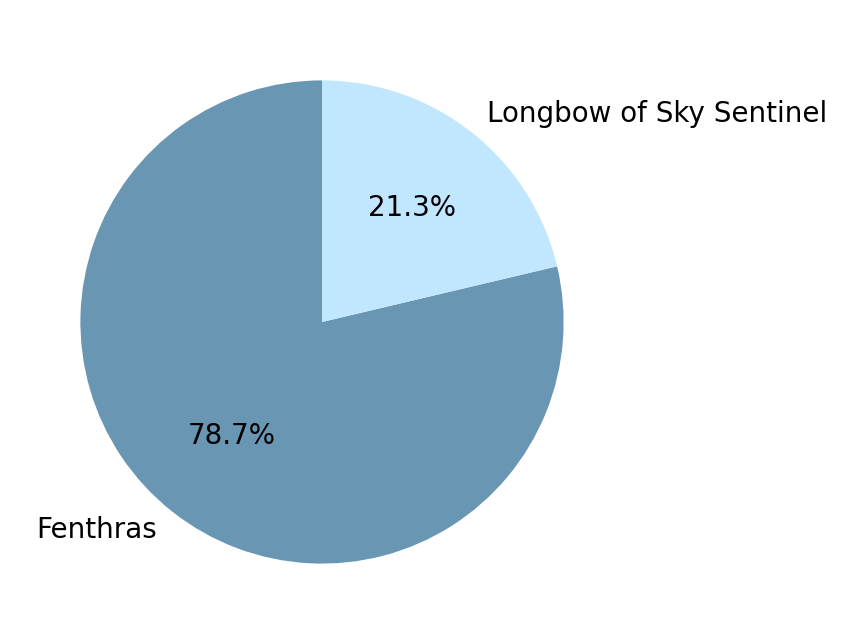

In [ ]:
total = len(y)
fen = (y == 'Fenthras').sum() #/ total
lss = total - fen
plt.figure(dpi=200)
plt.pie([fen, lss], labels=['Fenthras', 'Longbow of Sky Sentinel'],
        autopct='%1.1f%%', startangle=90, colors=['#6996b3', '#c1e7ff'])
#plt.show()
plt.savefig('pie.png')

Fenthras deals more damage in 78.7% of settings.

I am going to train a decision tree classifier on the data &mdash; to find out what are the conditions for using each bow.

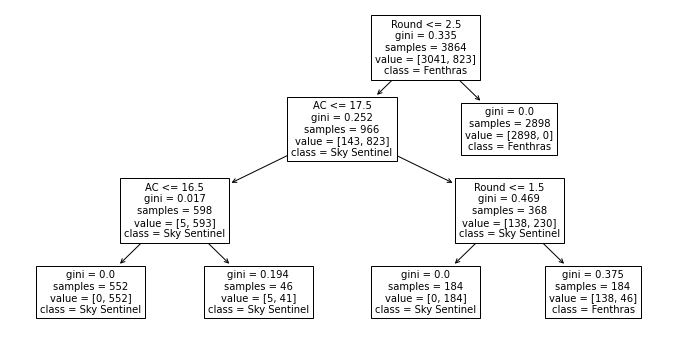

In [ ]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion='gini', max_depth=3)
clf = clf.fit(x, y)
plt.figure(figsize=(12, 6))
tree.plot_tree(clf, fontsize=10, feature_names=['Round', 'AC', 'STR save'],
               class_names = ['Fenthras', 'Sky Sentinel'])
plt.savefig('tree.png')

Here we go. Sorry for the primitive graphics. Let me explain. Each rectangle has five fields:
* splitting condition;
* gini &mdash; value of the measure of set's purity. Zero &mdash; when the set consists of data of a single class; one &mdash; when the set consists of two classes in *exactly equal* proportion. If this does not make any sense to you, disregard that;
* samples &mdash; the number of datapoints in a set;
* value &mdash; amount of datapoints in each class;
* class &mdash; the dominant class in the set.

For example, the top rectangle has splitting condition `round <= 2.5`, `gini = 0.335`, `samples = 3864`, `[3041, 823]`, `class = Fenthras`. This means that, before the splitting happens, there is a total of 3884 datapoints (different variations of parameters for combat) in 3041 of which Fenthras, on average, would do more damage and in 823 of which Longbow of Sky Sentinel would. `class = Fenthras` is there, because 3041 is more than 823 &mdash; if you don't know anything else, Fenthras is more likely to deal more damage.

There are 5 categories of situations; in 3 of them Longbow of Sky Sentinel wins, in 2 of them Fenthras does:
1. Combat last 3 or more rounds &mdash; Fenthras **definitely** wins.
2. Combat lasts 1 or 2 rounds and the enemy's Armor Class is lower than 16 or lower &mdash; Longbow of Sky Sentinel **definitely** wins.
3. Combat lasts for 1 round, enemy's Armor Class 17 or lower &mdash; Longbow of Sky Sentinel **definitely** wins.
4. Combat lasts 1 or 2 rounds, enemy's Armor Class is 17 or higher &mdash; Longbow of Sky Sentinel is probably a better choice.
5. Combat lasts 1 round, enemy's class is 18 or higher &mdash; Fenthras is probably a better choice.

To be more definitive about the last two categories, you can increase `max_depth` in `tree.DecisionTreeClassifier`. 

You can notice that target's strength save does not play a big role.

# So, is Fenthras better than Longbow of Sky Sentinel?
Yes. Damage from Longbow of Sky Sentinel is front-loaded &mdash; after a couple of rounds Fenthras is better.